# Part 1: The Position Problem — Why Transformers Need Help Knowing "Where"

**Understanding Positional Encodings in Transformers** | *A Six-Part Series*

---

📚 **Series Navigation:**
- **Part 1: The Position Problem & Sinusoidal PE** ← You are here
- Part 2: Learned Positional Embeddings - Coming Soon
- Part 3: RoPE (Rotary Position Embeddings) - Coming Soon
- Part 4: ALiBi (Attention with Linear Biases) - Coming Soon
- Part 5: PoPE (Polar Coordinate Embeddings) - Coming Soon
- Part 6: Practitioner's Guide - Coming Soon

---

## Introduction

Transformers have revolutionized natural language processing, computer vision, and many other domains. But there's a fundamental problem at their core: **self-attention is permutation-invariant**. 

This means that without additional information, a transformer treats "The cat sat on the mat" identically to "mat the on sat cat The" — clearly problematic for understanding language!

This notebook explores:
1. **Why** transformers need positional information
2. **How** the original 2017 solution (sinusoidal positional encoding) works
3. The **mathematical foundations** and intuitions behind it
4. **Visualizations** to build deep understanding

> 📄 **Paper:** [Attention Is All You Need](https://arxiv.org/abs/1706.03762) (Vaswani et al., 2017)

## 1. Import Required Libraries

First, let's import all the libraries we'll need. This notebook is fully self-contained.

In [ ]:
# Install dependencies (run once)
!pip install -q numpy matplotlib seaborn torch plotly

In [1]:
# Core libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from typing import Optional, Tuple

# Interactive visualization
import plotly.graph_objects as go
import plotly.express as px

# Set visualization styles
sns.set_style('whitegrid')
plt.rcParams['figure.dpi'] = 100
plt.rcParams['figure.figsize'] = [10, 6]

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

print("✓ All libraries imported successfully!")
print(f"PyTorch version: {torch.__version__}")

✓ All libraries imported successfully!
PyTorch version: 2.9.1+cu128


## 2. The Permutation Invariance Problem

### Why Transformers Can't Tell Position

Self-attention computes a weighted sum of all values, where weights depend only on the *content* of queries and keys — not their positions. Mathematically:

$$\text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V$$

**The problem:** If we shuffle the input tokens, the attention scores change, but the *set* of outputs remains the same (just reordered). The model has no way to know which token came first, second, etc.

Let's demonstrate this with a simple example:

In [2]:
# Demonstrate permutation invariance
class SimpleAttentionNoPE(nn.Module):
    """Self-attention without any positional encoding"""
    def __init__(self, d_model: int, n_heads: int):
        super().__init__()
        self.attn = nn.MultiheadAttention(d_model, n_heads, batch_first=True)
    
    def forward(self, x):
        output, attn_weights = self.attn(x, x, x)
        return output, attn_weights

# Create a simple model
model = SimpleAttentionNoPE(d_model=32, n_heads=4)
model.eval()

# Create token embeddings (imagine these are words)
# "The cat sat on the mat" → 6 tokens
tokens_original = torch.randn(1, 6, 32)

# Permute the tokens (shuffle the word order)
permutation = torch.tensor([2, 0, 4, 1, 5, 3])  # Random shuffle
tokens_permuted = tokens_original[:, permutation, :]

with torch.no_grad():
    out_original, attn_original = model(tokens_original)
    out_permuted, attn_permuted = model(tokens_permuted)

# Check if outputs are just permutations of each other
# Unpermute the permuted output to compare
inverse_perm = torch.argsort(permutation)
out_permuted_reordered = out_permuted[:, inverse_perm, :]

difference = torch.abs(out_original - out_permuted_reordered).mean().item()

print("=" * 60)
print("PERMUTATION INVARIANCE DEMONSTRATION")
print("=" * 60)
print(f"\nOriginal token order:  [0, 1, 2, 3, 4, 5]")
print(f"Permuted token order:  {permutation.tolist()}")
print(f"\nMean difference after unpermuting: {difference:.8f}")
print("\n→ The outputs are nearly identical (just reordered)!")
print("→ The model CANNOT distinguish word order without PE!")

PERMUTATION INVARIANCE DEMONSTRATION

Original token order:  [0, 1, 2, 3, 4, 5]
Permuted token order:  [2, 0, 4, 1, 5, 3]

Mean difference after unpermuting: 0.00000002

→ The outputs are nearly identical (just reordered)!
→ The model CANNOT distinguish word order without PE!


### Historical Context: How Did We Handle Position Before?

**RNNs and LSTMs (pre-2017):**
- Processed tokens *sequentially*, one at a time
- Position was implicit in the hidden state evolution
- The 5th hidden state "remembered" it had seen 4 tokens before

**Transformers (2017):**
- Process all tokens *in parallel* for efficiency
- No sequential processing → no implicit position
- **Solution:** Explicitly inject position information via "positional encodings"

The challenge: How do we encode position in a way that:
1. Is unique for each position
2. Generalizes to different sequence lengths
3. Allows the model to learn relative positions
4. Doesn't interfere with semantic meaning

## 3. Sinusoidal Positional Encoding: The Original Solution

### The Key Insight

Vaswani et al. (2017) proposed using **sine and cosine functions at different frequencies** to encode position. The intuition:

- Each dimension oscillates at a different rate
- Lower dimensions: high frequency (rapid oscillation)
- Higher dimensions: low frequency (slow oscillation)
- Together, they create a **unique "fingerprint" for each position**

Think of it like a clock with multiple hands moving at different speeds — at any moment, the combination of hand positions uniquely identifies the time.

### Mathematical Formulation

For position $\text{pos}$ and dimension $i$:

$$PE_{(\text{pos}, 2i)} = \sin\left(\frac{\text{pos}}{10000^{2i/d_{\text{model}}}}\right)$$

$$PE_{(\text{pos}, 2i+1)} = \cos\left(\frac{\text{pos}}{10000^{2i/d_{\text{model}}}}\right)$$

Where:
- $\text{pos}$: Position index (0, 1, 2, ...)
- $i$: Dimension pair index
- $d_{\text{model}}$: Total embedding dimension
- Even dimensions use sine, odd dimensions use cosine
- $10000$: Base that controls the wavelength range

In [3]:
def generate_sinusoidal_pe(seq_len: int, d_model: int) -> np.ndarray:
    """
    Generate sinusoidal positional encoding matrix.
    
    Args:
        seq_len: Maximum sequence length
        d_model: Dimension of the model (embedding size)
    
    Returns:
        Positional encoding matrix of shape (seq_len, d_model)
    """
    # Create position indices: [0, 1, 2, ..., seq_len-1]
    position = np.arange(seq_len)[:, np.newaxis]  # Shape: (seq_len, 1)
    
    # Create dimension indices for computing frequencies
    # We use pairs of dimensions, so we step by 2
    dim_indices = np.arange(0, d_model, 2)  # [0, 2, 4, ..., d_model-2]
    
    # Compute the division term: 10000^(2i/d_model)
    # This creates wavelengths from 2π to 10000*2π
    div_term = 10000 ** (dim_indices / d_model)  # Shape: (d_model/2,)
    
    # Initialize PE matrix
    pe = np.zeros((seq_len, d_model))
    
    # Apply sine to even indices
    pe[:, 0::2] = np.sin(position / div_term)
    
    # Apply cosine to odd indices
    pe[:, 1::2] = np.cos(position / div_term)
    
    return pe


# Generate positional encodings
d_model = 64
seq_len = 100

pe_matrix = generate_sinusoidal_pe(seq_len, d_model)

print(f"Generated positional encoding matrix: {pe_matrix.shape}")
print(f"  → {seq_len} positions × {d_model} dimensions")
print(f"Value range: [{pe_matrix.min():.3f}, {pe_matrix.max():.3f}]")
print("\n✓ Sinusoidal PE function implemented!")

Generated positional encoding matrix: (100, 64)
  → 100 positions × 64 dimensions
Value range: [-1.000, 1.000]

✓ Sinusoidal PE function implemented!


## 4. Visualizing the Positional Encoding Matrix

### Heatmap View

Let's visualize the full positional encoding matrix. Each row is a position, each column is a dimension.

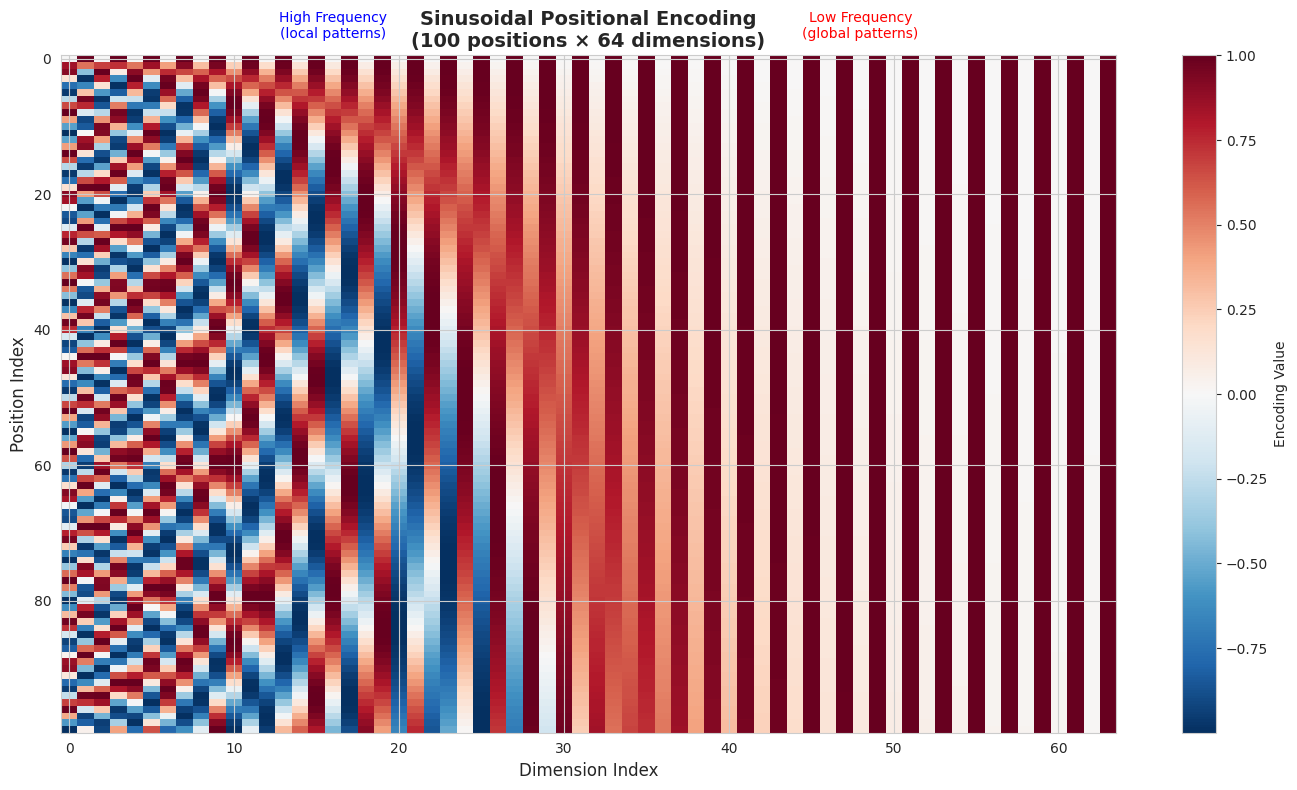

Key observations:
• Left side (low dimensions): Rapid oscillations — high frequency
• Right side (high dimensions): Slow oscillations — low frequency
• Each row (position) has a unique pattern across all dimensions


In [4]:
# Visualization 1: Full Heatmap
fig, ax = plt.subplots(figsize=(14, 8))

im = ax.imshow(pe_matrix, cmap='RdBu_r', aspect='auto', interpolation='nearest')
plt.colorbar(im, ax=ax, label='Encoding Value')

ax.set_xlabel('Dimension Index', fontsize=12)
ax.set_ylabel('Position Index', fontsize=12)
ax.set_title('Sinusoidal Positional Encoding\n(100 positions × 64 dimensions)', 
             fontsize=14, fontweight='bold')

# Add annotations for dimension types
ax.axhline(y=-0.5, color='black', linewidth=0.5)
ax.text(d_model//4, -3, 'High Frequency\n(local patterns)', ha='center', fontsize=10, color='blue')
ax.text(3*d_model//4, -3, 'Low Frequency\n(global patterns)', ha='center', fontsize=10, color='red')

plt.tight_layout()
plt.show()

print("Key observations:")
print("• Left side (low dimensions): Rapid oscillations — high frequency")
print("• Right side (high dimensions): Slow oscillations — low frequency")
print("• Each row (position) has a unique pattern across all dimensions")

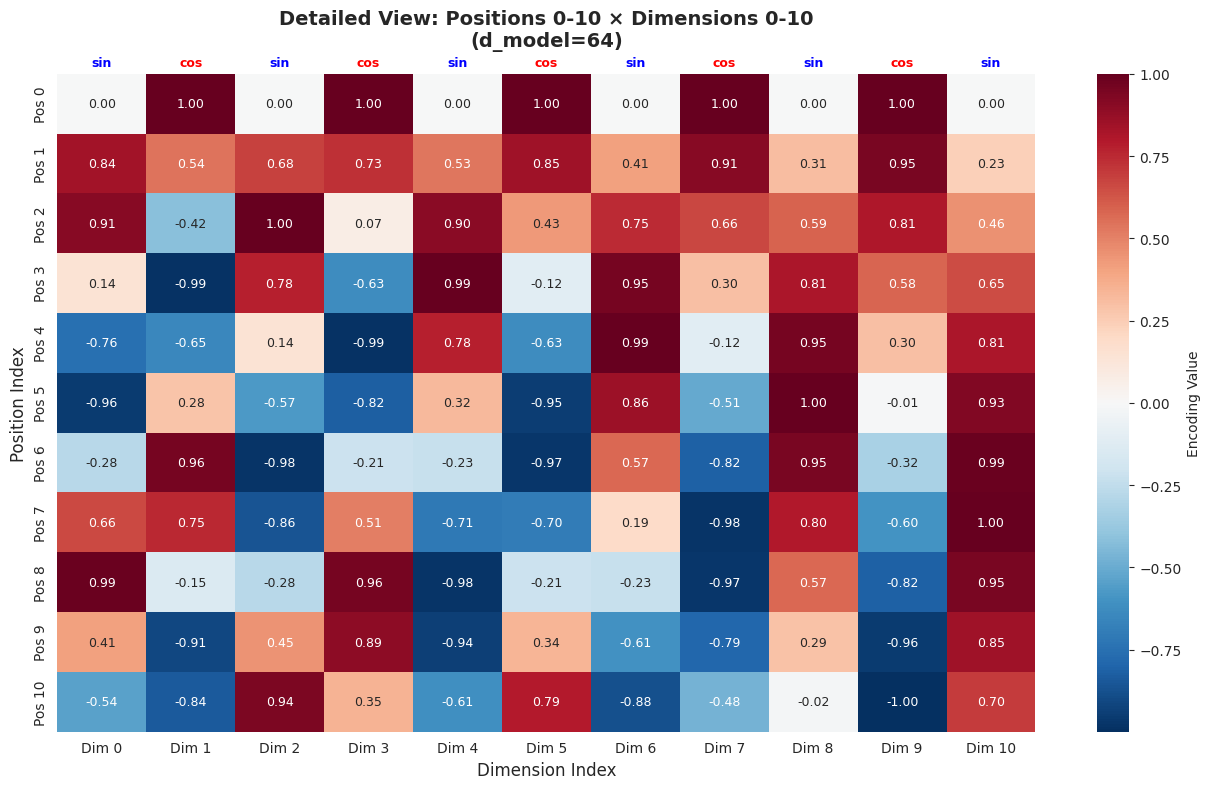


Pattern Analysis:
• Dim 0 (sin): Starts at 0.00, oscillates rapidly
• Dim 1 (cos): Starts at 1.00, oscillates rapidly
• Dim 10 (sin): Changes very slowly across positions
• Each position has a unique combination of values!


In [5]:
# Visualization 2: Detailed view of first 11 positions × 11 dimensions
pe_small = generate_sinusoidal_pe(11, 64)

fig, ax = plt.subplots(figsize=(13, 8))

sns.heatmap(pe_small[:, :11], 
            cmap='RdBu_r', 
            center=0, 
            ax=ax, 
            annot=True, 
            fmt='.2f',
            annot_kws={'size': 9},
            xticklabels=[f'Dim {i}' for i in range(11)],
            yticklabels=[f'Pos {i}' for i in range(11)],
            cbar_kws={'label': 'Encoding Value'})

ax.set_title('Detailed View: Positions 0-10 × Dimensions 0-10\n(d_model=64)', 
             fontsize=14, fontweight='bold', pad=20)
ax.set_xlabel('Dimension Index', fontsize=12)
ax.set_ylabel('Position Index', fontsize=12)

# Add sin/cos labels
for i in range(11):
    label = 'sin' if i % 2 == 0 else 'cos'
    color = 'blue' if i % 2 == 0 else 'red'
    ax.text(i + 0.5, -0.3, label, ha='center', va='top', fontsize=9, 
            color=color, fontweight='bold')

plt.tight_layout()
plt.show()

print("\nPattern Analysis:")
print("• Dim 0 (sin): Starts at 0.00, oscillates rapidly")
print("• Dim 1 (cos): Starts at 1.00, oscillates rapidly")
print("• Dim 10 (sin): Changes very slowly across positions")
print("• Each position has a unique combination of values!")

## 5. Individual Dimension Waves

Let's plot the values for individual dimensions across positions to see the wave patterns clearly.

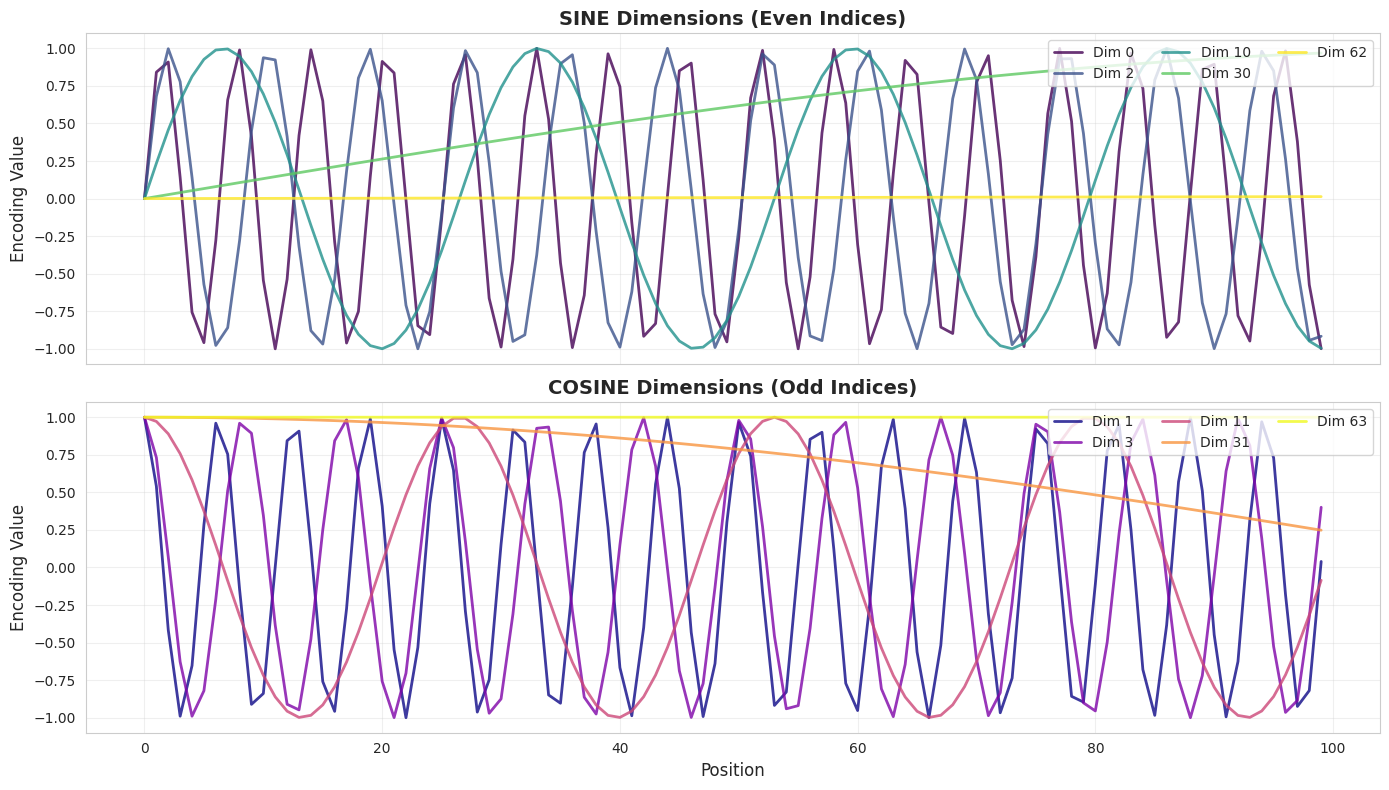

Key observations:
• Dim 0-3 (low indices): Complete multiple oscillations over 100 positions
• Dim 10-11 (mid indices): Slower oscillations
• Dim 30-31 (high indices): Very slow change
• Dim 62-63 (highest): Almost constant — encode very long-range patterns


In [6]:
# Plot individual dimensions
dims_to_show = [0, 1, 2, 3, 10, 11, 30, 31, 62, 63]
positions = np.arange(100)

fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

# Sine dimensions (even)
ax1 = axes[0]
sine_dims = [d for d in dims_to_show if d % 2 == 0]
colors = plt.cm.viridis(np.linspace(0, 1, len(sine_dims)))
for dim, color in zip(sine_dims, colors):
    ax1.plot(positions, pe_matrix[:, dim], label=f'Dim {dim}', 
             linewidth=2, alpha=0.8, color=color)
ax1.set_ylabel('Encoding Value', fontsize=12)
ax1.set_title('SINE Dimensions (Even Indices)', fontsize=14, fontweight='bold')
ax1.legend(loc='upper right', ncol=3)
ax1.grid(True, alpha=0.3)
ax1.set_ylim(-1.1, 1.1)

# Cosine dimensions (odd)
ax2 = axes[1]
cosine_dims = [d for d in dims_to_show if d % 2 == 1]
colors = plt.cm.plasma(np.linspace(0, 1, len(cosine_dims)))
for dim, color in zip(cosine_dims, colors):
    ax2.plot(positions, pe_matrix[:, dim], label=f'Dim {dim}', 
             linewidth=2, alpha=0.8, color=color)
ax2.set_xlabel('Position', fontsize=12)
ax2.set_ylabel('Encoding Value', fontsize=12)
ax2.set_title('COSINE Dimensions (Odd Indices)', fontsize=14, fontweight='bold')
ax2.legend(loc='upper right', ncol=3)
ax2.grid(True, alpha=0.3)
ax2.set_ylim(-1.1, 1.1)

plt.tight_layout()
plt.show()

print("Key observations:")
print("• Dim 0-3 (low indices): Complete multiple oscillations over 100 positions")
print("• Dim 10-11 (mid indices): Slower oscillations")
print("• Dim 30-31 (high indices): Very slow change")
print("• Dim 62-63 (highest): Almost constant — encode very long-range patterns")

## 6. Interactive 3D Visualization

Let's see how positions are distributed when we look at just the first 3 dimensions of the positional encoding.

In [7]:
# 3D visualization using first 3 dimensions
pe_50 = generate_sinusoidal_pe(50, d_model)

fig = go.Figure(data=[go.Scatter3d(
    x=pe_50[:, 0],
    y=pe_50[:, 1],
    z=pe_50[:, 2],
    mode='markers+lines',
    marker=dict(
        size=6,
        color=np.arange(50),
        colorscale='Viridis',
        colorbar=dict(title='Position'),
        opacity=0.8
    ),
    line=dict(color='gray', width=2),
    text=[f'Position {i}' for i in range(50)],
    hoverinfo='text'
)])

fig.update_layout(
    title=dict(
        text='Positional Encodings in 3D Space (Dimensions 0, 1, 2)',
        font=dict(size=16)
    ),
    scene=dict(
        xaxis_title='Dimension 0 (sin)',
        yaxis_title='Dimension 1 (cos)',
        zaxis_title='Dimension 2 (sin)',
        camera=dict(eye=dict(x=1.5, y=1.5, z=1.2))
    ),
    width=800,
    height=600
)

fig.show()

print("Interact with the plot:")
print("• Rotate, zoom, and pan to explore the 3D structure")
print("• Hover over points to see position numbers")
print("• Notice how positions trace a smooth path through 3D space")
print("• The spiral pattern comes from combining sin and cos at different frequencies")

Interact with the plot:
• Rotate, zoom, and pan to explore the 3D structure
• Hover over points to see position numbers
• Notice how positions trace a smooth path through 3D space
• The spiral pattern comes from combining sin and cos at different frequencies


## 7. Understanding the Wavelength Progression

A critical insight: the wavelengths increase **exponentially** across dimensions. This creates a multi-scale encoding where different dimensions capture patterns at different ranges.

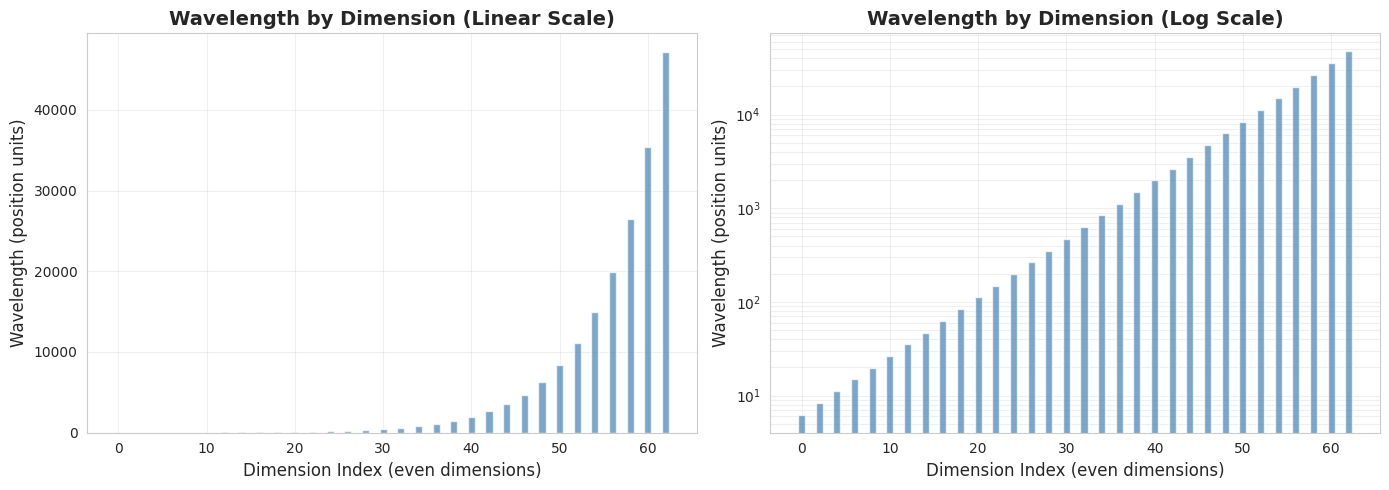

Sample wavelengths:
  Dimension 0:  6.28 positions (completes ~15.9 cycles in 100 positions)
  Dimension 10: 26.50 positions
  Dimension 30: 471.17 positions
  Dimension 62: 4.71e+04 positions (extremely long wavelength)

→ Exponential progression from ~6 positions to ~63,000 positions!


In [8]:
# Compute wavelengths for each dimension pair
def compute_wavelength(dim_pair: int, d_model: int) -> float:
    """Compute the wavelength (in position units) for a dimension pair"""
    return 2 * np.pi * (10000 ** (2 * dim_pair / d_model))

# Calculate wavelengths for all dimension pairs
dim_pairs = np.arange(d_model // 2)
wavelengths = [compute_wavelength(i, d_model) for i in dim_pairs]

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Linear scale
ax1 = axes[0]
ax1.bar(dim_pairs * 2, wavelengths, color='steelblue', alpha=0.7)
ax1.set_xlabel('Dimension Index (even dimensions)', fontsize=12)
ax1.set_ylabel('Wavelength (position units)', fontsize=12)
ax1.set_title('Wavelength by Dimension (Linear Scale)', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)

# Log scale
ax2 = axes[1]
ax2.bar(dim_pairs * 2, wavelengths, color='steelblue', alpha=0.7)
ax2.set_xlabel('Dimension Index (even dimensions)', fontsize=12)
ax2.set_ylabel('Wavelength (position units)', fontsize=12)
ax2.set_title('Wavelength by Dimension (Log Scale)', fontsize=14, fontweight='bold')
ax2.set_yscale('log')
ax2.grid(True, alpha=0.3, which='both')

plt.tight_layout()
plt.show()

# Print some specific wavelengths
print("Sample wavelengths:")
print(f"  Dimension 0:  {wavelengths[0]:.2f} positions (completes ~{100/wavelengths[0]:.1f} cycles in 100 positions)")
print(f"  Dimension 10: {wavelengths[5]:.2f} positions")
print(f"  Dimension 30: {wavelengths[15]:.2f} positions")
print(f"  Dimension 62: {wavelengths[31]:.2e} positions (extremely long wavelength)")
print("\n→ Exponential progression from ~6 positions to ~63,000 positions!")

## 8. PyTorch Implementation: Sinusoidal PE Module

Now let's implement a proper PyTorch module that can be used in a transformer.

In [9]:
class SinusoidalPositionalEncoding(nn.Module):
    """
    Sinusoidal positional encoding module for transformers.
    
    This module adds fixed sinusoidal positional encodings to input embeddings,
    following the original "Attention Is All You Need" paper (Vaswani et al., 2017).
    
    Args:
        d_model: Dimension of the model embeddings
        max_len: Maximum sequence length to precompute
        dropout: Dropout probability applied after adding PE
    """
    
    def __init__(self, d_model: int, max_len: int = 5000, dropout: float = 0.1):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)
        
        # Create positional encoding matrix
        pe = torch.zeros(max_len, d_model)
        
        # Position indices: [0, 1, 2, ..., max_len-1]
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        
        # Compute division term for frequencies
        # exp(arange * -log(10000) / d_model) = 10000^(-arange/d_model)
        div_term = torch.exp(
            torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model)
        )
        
        # Apply sine to even indices
        pe[:, 0::2] = torch.sin(position * div_term)
        # Apply cosine to odd indices
        pe[:, 1::2] = torch.cos(position * div_term)
        
        # Add batch dimension: (1, max_len, d_model)
        pe = pe.unsqueeze(0)
        
        # Register as buffer (saved with model, but not a parameter)
        self.register_buffer('pe', pe)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Add positional encoding to input embeddings.
        
        Args:
            x: Input tensor of shape (batch_size, seq_len, d_model)
        
        Returns:
            Tensor with positional encoding added, same shape as input
        """
        # Add positional encoding (broadcasts across batch)
        x = x + self.pe[:, :x.size(1), :]
        return self.dropout(x)


# Test the module
batch_size = 2
seq_len = 10
d_model = 64

pos_encoder = SinusoidalPositionalEncoding(d_model)

# Create dummy input (simulating token embeddings)
x = torch.randn(batch_size, seq_len, d_model)

# Apply positional encoding
output = pos_encoder(x)

print(f"Input shape:  {x.shape}")
print(f"Output shape: {output.shape}")
print(f"PE buffer shape: {pos_encoder.pe.shape}")
print(f"\n✓ SinusoidalPositionalEncoding module working!")

Input shape:  torch.Size([2, 10, 64])
Output shape: torch.Size([2, 10, 64])
PE buffer shape: torch.Size([1, 5000, 64])

✓ SinusoidalPositionalEncoding module working!


## 9. A Simple Transformer Layer with Positional Encoding

Let's combine our positional encoding with self-attention to build a simple transformer layer.

In [10]:
class SimpleTransformerLayer(nn.Module):
    """
    A simple transformer layer demonstrating positional encoding usage.
    
    Components:
    1. Positional encoding (added to input)
    2. Multi-head self-attention
    3. Layer normalization with residual connection
    """
    
    def __init__(self, d_model: int, n_heads: int, dropout: float = 0.1):
        super().__init__()
        self.pos_encoding = SinusoidalPositionalEncoding(d_model, dropout=dropout)
        self.self_attn = nn.MultiheadAttention(
            d_model, n_heads, dropout=dropout, batch_first=True
        )
        self.norm = nn.LayerNorm(d_model)
        
    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Forward pass through the transformer layer.
        
        Args:
            x: Input tensor of shape (batch_size, seq_len, d_model)
        
        Returns:
            output: Transformed tensor, same shape as input
            attn_weights: Attention weight matrix (batch, seq_len, seq_len)
        """
        # Add positional encoding
        x_pos = self.pos_encoding(x)
        
        # Self-attention
        attn_output, attn_weights = self.self_attn(x_pos, x_pos, x_pos)
        
        # Residual connection and normalization
        output = self.norm(x + attn_output)
        
        return output, attn_weights


# Create and test the layer
layer = SimpleTransformerLayer(d_model=64, n_heads=8)
x = torch.randn(2, 20, 64)  # (batch, seq_len, d_model)

output, attn_weights = layer(x)

print(f"Input shape: {x.shape}")
print(f"Output shape: {output.shape}")
print(f"Attention weights shape: {attn_weights.shape}")
print("\n✓ Transformer layer with positional encoding working!")

Input shape: torch.Size([2, 20, 64])
Output shape: torch.Size([2, 20, 64])
Attention weights shape: torch.Size([2, 20, 20])

✓ Transformer layer with positional encoding working!


## 10. Visualizing Attention Patterns

Let's look at how the attention weights are distributed. With positional encoding, we expect the model to develop position-aware attention patterns.

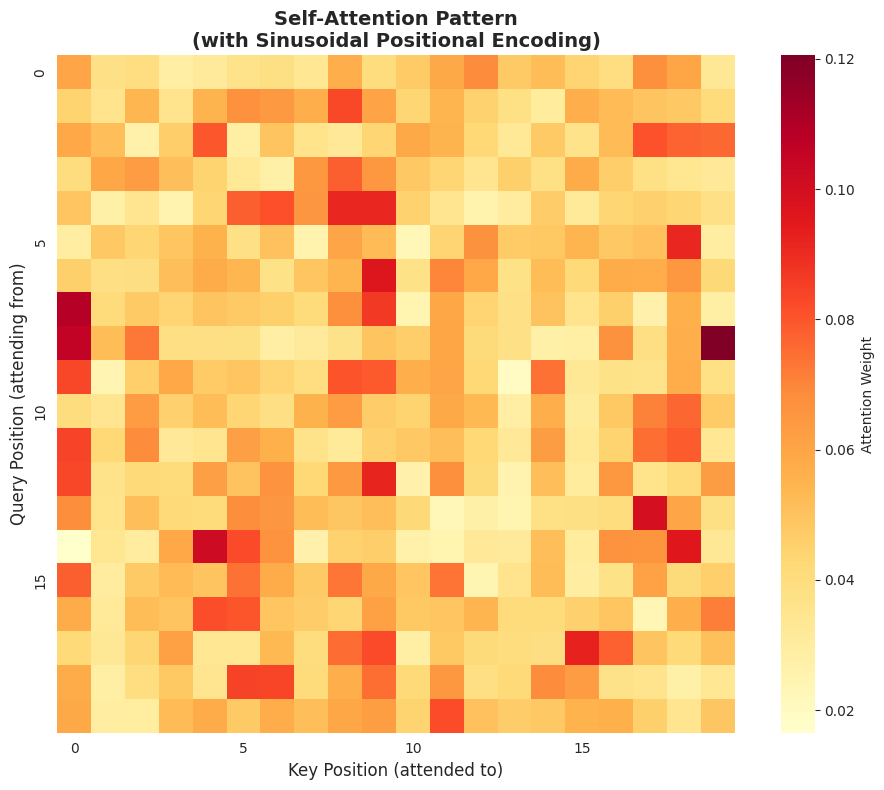

The attention pattern shows how each position (row) attends to other positions (columns).
With PE, the model can learn position-dependent attention patterns.

Note: This is a randomly initialized model — trained models show more structured patterns.


In [11]:
# Visualize attention patterns
fig, ax = plt.subplots(figsize=(10, 8))

# Get attention weights from first sample
attn_matrix = attn_weights[0].detach().numpy()

sns.heatmap(attn_matrix, 
            cmap='YlOrRd', 
            ax=ax, 
            square=True,
            cbar_kws={'label': 'Attention Weight'},
            xticklabels=5,
            yticklabels=5)

ax.set_xlabel('Key Position (attended to)', fontsize=12)
ax.set_ylabel('Query Position (attending from)', fontsize=12)
ax.set_title('Self-Attention Pattern\n(with Sinusoidal Positional Encoding)', 
             fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print("The attention pattern shows how each position (row) attends to other positions (columns).")
print("With PE, the model can learn position-dependent attention patterns.")
print("\nNote: This is a randomly initialized model — trained models show more structured patterns.")

## 11. The Critical Question: Does PE Contaminate Token Meaning?

You might wonder: by adding positional encoding directly to token embeddings, aren't we "contaminating" the semantic meaning of words?

**Yes, we are mixing signals — and this is a known limitation!**

Let's analyze the magnitude of this mixing:

MAGNITUDE ANALYSIS: Token vs Positional Encoding

Token embedding norm:     5.5801
Positional encoding norm: 8.0000
Combined norm:            10.1047

Angle between original token emb and combined: 52.12°
  (0° = identical direction, 90° = orthogonal)


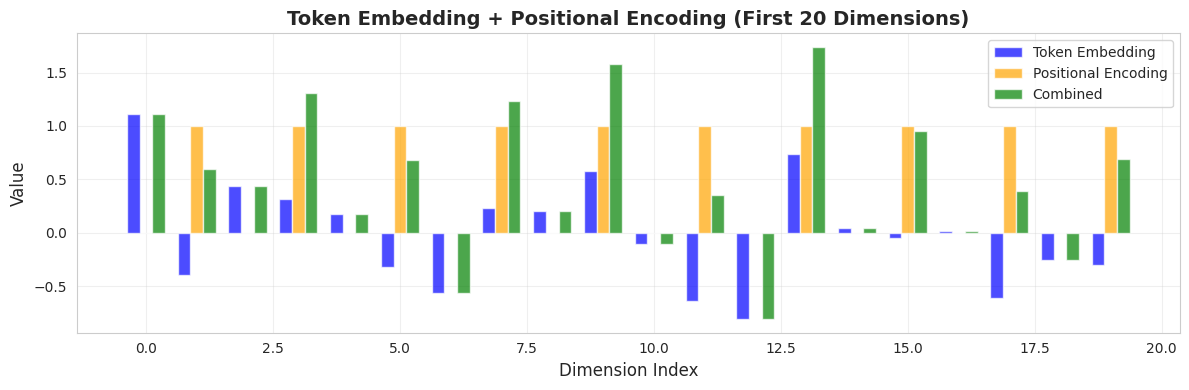


WHY IT STILL WORKS:
1. High-dimensional space has room for both signals
2. The model learns to disentangle during training
3. PE values are bounded in [-1, 1]

BUT: Modern methods (RoPE, ALiBi, PoPE) address this better!
     → See Parts 3, 4, and 5 of this series


In [12]:
# Analyze the mixing of token and positional information
token_emb = torch.randn(1, 128) * 0.5  # Typical embedding initialization scale
pos_enc = torch.tensor(generate_sinusoidal_pe(1, 128), dtype=torch.float32)

# Compute norms
token_norm = torch.norm(token_emb).item()
pos_norm = torch.norm(pos_enc).item()
combined = token_emb + pos_enc
combined_norm = torch.norm(combined).item()

# Compute angle between original and combined
dot_product = torch.dot(token_emb.flatten().float(), combined.flatten().float()).item()
cos_angle = dot_product / (token_norm * combined_norm)
angle_degrees = np.degrees(np.arccos(np.clip(cos_angle, -1, 1)))

print("=" * 60)
print("MAGNITUDE ANALYSIS: Token vs Positional Encoding")
print("=" * 60)
print(f"\nToken embedding norm:     {token_norm:.4f}")
print(f"Positional encoding norm: {pos_norm:.4f}")
print(f"Combined norm:            {combined_norm:.4f}")
print(f"\nAngle between original token emb and combined: {angle_degrees:.2f}°")
print("  (0° = identical direction, 90° = orthogonal)")

# Visualize
fig, ax = plt.subplots(figsize=(12, 4))
dims_to_show = 20
x_pos = np.arange(dims_to_show)
width = 0.25

ax.bar(x_pos - width, token_emb[0, :dims_to_show].numpy(), width, 
       label='Token Embedding', alpha=0.7, color='blue')
ax.bar(x_pos, pos_enc[0, :dims_to_show].numpy(), width, 
       label='Positional Encoding', alpha=0.7, color='orange')
ax.bar(x_pos + width, combined[0, :dims_to_show].numpy(), width, 
       label='Combined', alpha=0.7, color='green')

ax.set_xlabel('Dimension Index', fontsize=12)
ax.set_ylabel('Value', fontsize=12)
ax.set_title('Token Embedding + Positional Encoding (First 20 Dimensions)', 
             fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "=" * 60)
print("WHY IT STILL WORKS:")
print("=" * 60)
print("1. High-dimensional space has room for both signals")
print("2. The model learns to disentangle during training")
print("3. PE values are bounded in [-1, 1]")
print("\nBUT: Modern methods (RoPE, ALiBi, PoPE) address this better!")
print("     → See Parts 3, 4, and 5 of this series")

## 12. Properties of Sinusoidal Positional Encoding

Let's verify some key mathematical properties that make sinusoidal PE effective.

### Property 1: Bounded Values
All PE values are in [-1, 1], preventing gradient explosion.

Property 1: Bounded Values
  PE matrix shape: (10000, 512)
  Min value: -1.000000
  Max value: 1.000000
  ✓ All values in [-1, 1] as expected from sin/cos

Property 2: Unique Positions
  Checking 1000 positions...
  Unique encoding vectors: 1000
  ✓ Each position has a unique encoding

Property 3: Relative Position Awareness


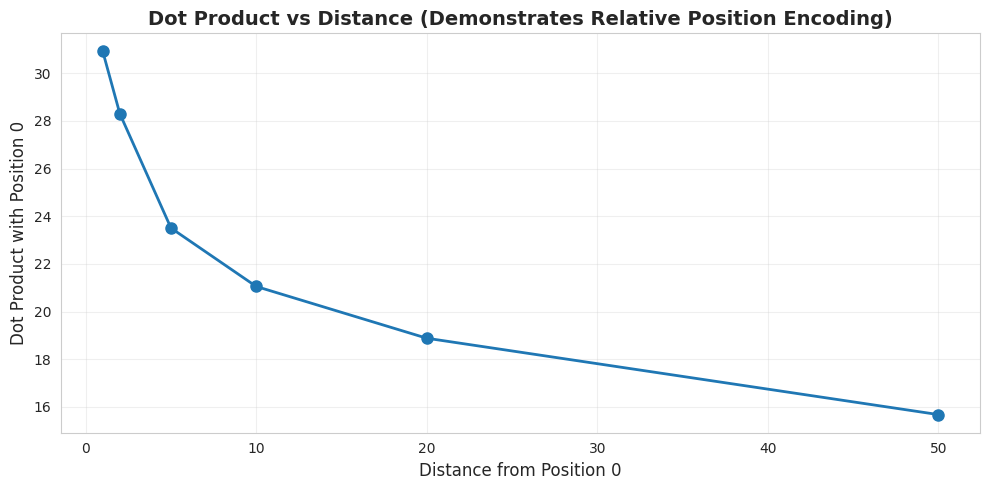

  Dot product decreases with distance, encoding relative position!


In [13]:
# Property 1: Bounded values
pe_long = generate_sinusoidal_pe(10000, 512)
print("Property 1: Bounded Values")
print(f"  PE matrix shape: {pe_long.shape}")
print(f"  Min value: {pe_long.min():.6f}")
print(f"  Max value: {pe_long.max():.6f}")
print("  ✓ All values in [-1, 1] as expected from sin/cos")

# Property 2: Unique positions
print("\nProperty 2: Unique Positions")
# Check if any two positions have identical encodings
n_positions = 1000
pe_check = generate_sinusoidal_pe(n_positions, 64)
unique_rows = len(np.unique(pe_check, axis=0))
print(f"  Checking {n_positions} positions...")
print(f"  Unique encoding vectors: {unique_rows}")
print(f"  ✓ Each position has a unique encoding")

# Property 3: Relative position via dot product
print("\nProperty 3: Relative Position Awareness")
# Dot products should decrease as distance increases
pos_0 = pe_check[0]
distances = [1, 2, 5, 10, 20, 50]
dot_products = [np.dot(pos_0, pe_check[d]) for d in distances]

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(distances, dot_products, 'o-', linewidth=2, markersize=8)
ax.set_xlabel('Distance from Position 0', fontsize=12)
ax.set_ylabel('Dot Product with Position 0', fontsize=12)
ax.set_title('Dot Product vs Distance (Demonstrates Relative Position Encoding)', 
             fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("  Dot product decreases with distance, encoding relative position!")

## 13. The Relative Position Property

One of the most elegant aspects of sinusoidal PE is that relative positions can be expressed as linear transformations. Due to trigonometric identities:

$$\sin(\alpha + \beta) = \sin\alpha\cos\beta + \cos\alpha\sin\beta$$
$$\cos(\alpha + \beta) = \cos\alpha\cos\beta - \sin\alpha\sin\beta$$

This means that $PE_{pos+k}$ can be expressed as a **linear function** of $PE_{pos}$!

Testing: Can PE[pos+k] be computed from PE[pos] via linear transform?

Offset k = 5
Predicting PE[10] from PE[5]...
Prediction error: 5.14e-16
✓ Near-zero error confirms the linear transformation property!


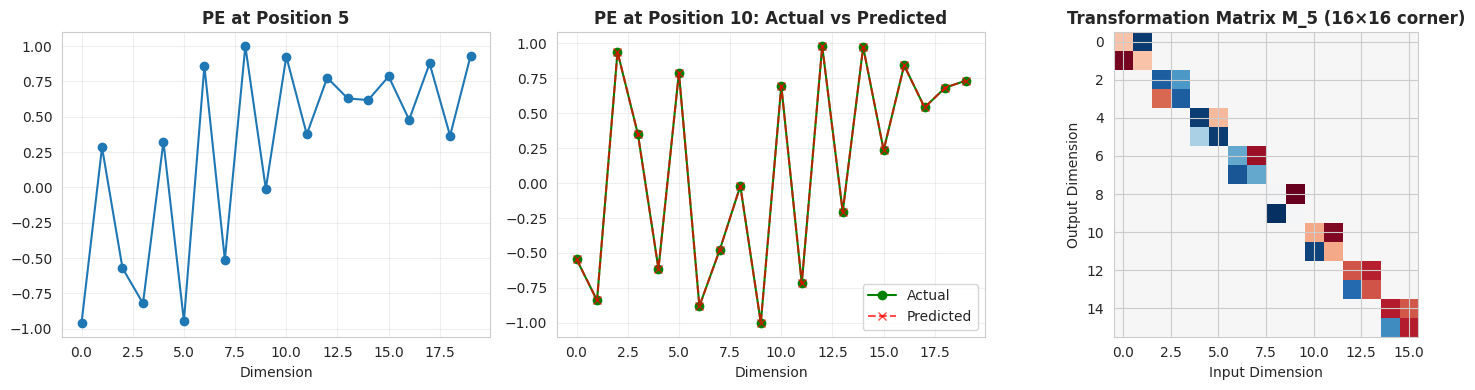


The block-diagonal structure shows 2×2 rotation matrices for each dimension pair.


In [14]:
# Demonstrate the linear transformation property
def relative_position_matrix(k: int, d_model: int) -> np.ndarray:
    """
    Compute the matrix M_k such that PE[pos+k] ≈ M_k @ PE[pos]
    for each dimension pair.
    
    For a sin/cos pair with frequency omega:
    [sin((pos+k)*omega)]   [cos(k*omega)   sin(k*omega)] [sin(pos*omega)]
    [cos((pos+k)*omega)] = [-sin(k*omega)  cos(k*omega)] [cos(pos*omega)]
    """
    # For each pair of dimensions, create a 2x2 rotation matrix
    n_pairs = d_model // 2
    M = np.zeros((d_model, d_model))
    
    for i in range(n_pairs):
        omega = 1.0 / (10000 ** (2 * i / d_model))
        angle = k * omega
        
        # Rotation matrix for this pair
        cos_k = np.cos(angle)
        sin_k = np.sin(angle)
        
        # Place in the big matrix (dimensions 2i and 2i+1)
        M[2*i, 2*i] = cos_k
        M[2*i, 2*i+1] = sin_k
        M[2*i+1, 2*i] = -sin_k
        M[2*i+1, 2*i+1] = cos_k
    
    return M


# Test: Can we predict PE[pos+k] from PE[pos] using a linear transform?
d_test = 64
pe_test = generate_sinusoidal_pe(100, d_test)

# For offset k=5, predict PE[10] from PE[5]
k = 5
M_k = relative_position_matrix(k, d_test)

pe_5 = pe_test[5]
pe_10_predicted = M_k @ pe_5
pe_10_actual = pe_test[10]

error = np.linalg.norm(pe_10_predicted - pe_10_actual)

print("Testing: Can PE[pos+k] be computed from PE[pos] via linear transform?")
print(f"\nOffset k = {k}")
print(f"Predicting PE[10] from PE[5]...")
print(f"Prediction error: {error:.2e}")
print("✓ Near-zero error confirms the linear transformation property!")

# Visualize
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].plot(pe_5[:20], 'o-', label='PE[5]')
axes[0].set_title('PE at Position 5', fontweight='bold')
axes[0].set_xlabel('Dimension')
axes[0].grid(True, alpha=0.3)

axes[1].plot(pe_10_actual[:20], 'o-', label='Actual', color='green')
axes[1].plot(pe_10_predicted[:20], 'x--', label='Predicted', color='red', alpha=0.7)
axes[1].set_title('PE at Position 10: Actual vs Predicted', fontweight='bold')
axes[1].set_xlabel('Dimension')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Show the transformation matrix structure
axes[2].imshow(M_k[:16, :16], cmap='RdBu_r', aspect='equal')
axes[2].set_title(f'Transformation Matrix M_{k} (16×16 corner)', fontweight='bold')
axes[2].set_xlabel('Input Dimension')
axes[2].set_ylabel('Output Dimension')

plt.tight_layout()
plt.show()

print("\nThe block-diagonal structure shows 2×2 rotation matrices for each dimension pair.")

## 14. Limitations of Sinusoidal PE

While sinusoidal PE was groundbreaking in 2017, it has several limitations that motivated later improvements:

### Limitation 1: Mixing of Semantic and Positional Information

As we saw earlier, adding PE to token embeddings mixes the signals.

### Limitation 2: Relative Position is Implicit

The model must *learn* to extract relative positions from the combined embedding. RoPE (Part 3) makes this explicit.

### Limitation 3: Fixed Encoding

The encoding is deterministic and cannot adapt to task-specific positional patterns. Learned embeddings (Part 2) address this.

### Limitation 4: No Causal Structure

The same PE is used for all attention patterns. ALiBi (Part 4) introduces explicit distance penalties.

## 15. Summary and Key Takeaways

### What We Learned

1. **The Position Problem**: Transformers are permutation-invariant without PE
   - Self-attention treats input as an unordered set
   - Word order is lost without explicit position information

2. **Sinusoidal PE Solution** (Vaswani et al., 2017):
   - Uses sine and cosine functions at different frequencies
   - Lower dimensions: high frequency (local patterns)
   - Higher dimensions: low frequency (global patterns)
   - Creates unique "fingerprint" for each position

3. **Mathematical Formula**:
   $$PE_{(pos, 2i)} = \sin\left(\frac{pos}{10000^{2i/d}}\right)$$
   $$PE_{(pos, 2i+1)} = \cos\left(\frac{pos}{10000^{2i/d}}\right)$$

4. **Key Properties**:
   - Bounded values [-1, 1]
   - Unique encoding for each position
   - Relative positions expressible as linear transforms

5. **Limitations**:
   - Mixes semantic and positional information
   - Relative position is implicit, not explicit
   - Cannot adapt to task-specific patterns

### Coming Up Next

**Part 2: Learned Positional Embeddings**
- The BERT/GPT-2 approach: just learn the positions!
- Trade-offs between fixed and learned encodings
- The extrapolation problem

---

### References

1. **Vaswani, A., et al.** (2017). "Attention Is All You Need." *NeurIPS*.
   - [arxiv.org/abs/1706.03762](https://arxiv.org/abs/1706.03762)
   - The original transformer paper introducing sinusoidal PE

2. **Shaw, P., et al.** (2018). "Self-Attention with Relative Position Representations." *NAACL*.
   - [arxiv.org/abs/1803.02155](https://arxiv.org/abs/1803.02155)
   - Early work on explicit relative position encoding

---

*Last updated: January 2026*